# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
https://stackoverflow.com/questions/50937591/pyspark-random-forest-feature-importance-mapping-after-column-transformations
https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241


In [1]:
# import libraries
import time
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import substring, col, round, when
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DateType, IntegerType, TimestampType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import rank

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, PCA, StandardScaler, MinMaxScaler, StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from distutils.version import LooseVersion

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# load data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [5]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [23]:
def data_processing(path):
    
    df = spark.read.json(path)
    
    # drop rows with missing or invalid values in either 'userId' or 'sessionId'
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")

    # label user 'Cancellation Confirmation' as churn
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", flag_cancellation_event("page"))
    
    # for each user, calculate total number of days from registration to last day activity 
    df = df.withColumn("totalDays", round((df.ts - df.registration)/(1000*60*60*24), 5))
    df = df.withColumn('totalDays', when(df.totalDays < 1, 1).otherwise(df.totalDays))

    # convert user systems into four categories: Windows, Apple, Linux, other
    df = df.withColumn('system',
                        when(col("userAgent").contains('Windows'), 'Windows')
                        .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone')) | (col("userAgent").contains('iPad')), 'Apple')
                        .when(col("userAgent").contains('Linux'), 'Linux')
                        .otherwise('other'))

    # create a datetime window to rank each user' activity from latest to earliest
    windowval = Window.partitionBy("userId").orderBy(desc("ts"))
    df = df.withColumn("rank", rank().over(windowval))

    # find each user's latest status of churn, gender, system, level
    df1 = df.select('userId', 'churn', 'gender', 'system', 'level').filter(df.rank == 1)
    
    df2 = df.filter(df.page == 'NextSong') \
            .groupby("userId") \
            .agg({'length':'sum', '*':'count'}) 
 #           .withColumnRenamed('sum(length)', 'songHours') \
  #          .withColumnRename('count(*)', 'n_NextSong')

#    select userId, cast(sum(length)/(60*60) as float) as songHours, count(*) as n_NextSong

    
    return df2


In [24]:
df = data_processing(path)
df.show(5)

+------+------------------+--------+
|userId|       sum(length)|count(1)|
+------+------------------+--------+
|100010|       66940.89735|     275|
|200002| 94008.87593999993|     387|
|   125|2089.1131000000005|       8|
|    51| 523275.8428000004|    2111|
|   124|1012312.0927900008|    4079|
+------+------------------+--------+
only showing top 5 rows



In [ ]:
    df.createOrReplaceTempView("df_sql")

    # find if a user has ever churned, and his/her max registration as YYYYMM format
    df1 = spark.sql(
    """
    select userId, max(churn) as churn, left(max(registration), 7) as registrationYearMonth
    from df_sql
    group by userId
    """)

    # find each user's latest status of gender, state, system, level
    df2 = spark.sql(
    """
    select distinct userId, gender, state, system, level
    from df_sql
    where rank == 1
    """)

    # find each users' total number of days (from registration dateto latest activity date)
    # find each users' actual number of active days divided by the total number of days
    # find each user' total number of sessions divided by the number of active days
    # find each user's total number of page items divided by the total number of sessions
    df3 = spark.sql(
    """
    select userId, totalDays, activeDays,
            cast(activeDays/totalDays as float) as activeDaysPct, 
            cast(session_ct/activeDays as float) session_perActiveDay, 
            cast(item_ct/session_ct as float) item_perSession
    from
        (select userId, max(totalDays) as totalDays, count(distinct(cast(datetime as DATE))) as activeDays, 
                count(distinct sessionId) as session_ct, count(itemInsession) as item_ct
        from df_sql
        group by userId) t 
    """)

    # find each users' total number of songs listened, and the total length/duration of songs listened
    df4 = spark.sql(
    """
    select userId, cast(sum(length)/(60*60) as float) as songHours, count(*) as n_NextSong
    from df_sql
    where page == 'NextSong'
    group by userId
    """)

    # this pivot has simpler codes in Pyspark Dataframe, than in Spark SQL
    # ignore 'Cancel', 'Cancellation Confirmation', pivot 'page' column, and fill na with 0
    df5 = df.filter(~df.page.contains('Cancel')).groupby("userId").pivot("page").count().fillna(0)

    # https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241
    # rename names for each page
    new_column_name_list= list(map(lambda x: 'n_' + x.replace(" ", ""), df5.columns))
    df5 = df5.toDF(*new_column_name_list)

    # chnage 'n_userId' back to 'userId'
    df5 = df5.withColumnRenamed('n_userId', 'userId')

    # for each user, calculate the average number of page views per song (NextSong)
    # keep 5 decimal
    for col_name in df5.columns:
        if col_name not in ('userId', 'n_NextSong'):
            df5 = df5.withColumn(col_name + '_perSong', round(col(col_name)/col("n_NextSong"), 5))

    df5_drop = ('n_About',
     'n_AddFriend',
     'n_AddtoPlaylist',
     'n_Downgrade',
     'n_Error',
     'n_Help',
     'n_Home',
     'n_Logout',
     'n_NextSong',
     'n_RollAdvert',
     'n_SaveSettings',
     'n_Settings',
     'n_SubmitDowngrade',
     'n_SubmitUpgrade',
     'n_ThumbsDown',
     'n_ThumbsUp',
     'n_Upgrade')

    # after calculating the average number of page views per song, drop the total number of page views for each user
    df5 = df5.drop(*df5_drop)

    # join all dataframes together to get the features
    df6 = df1.join(df2, on='userId').join(df3, on='userId').join(df4, on='userId').join(df5, on='userId')

    # create two more potential numeric features
    df6 = df6.withColumn('songs_perActiveDay', round(df6.n_NextSong/df6.activeDays, 1))
    df6 = df6.withColumn('songHours_perActiveDay', round(df6.songHours/df6.activeDays, 2))

    # cache for later usage
    df6.cache()

    df6_num_cols = ['totalDays',
     'activeDays',
     'activeDaysPct',
     'session_perActiveDay',
     'item_perSession',
     'songHours',
     'n_NextSong',
     'n_About_perSong',
     'n_AddFriend_perSong',
     'n_AddtoPlaylist_perSong',
     'n_Downgrade_perSong',
     'n_Error_perSong',
     'n_Help_perSong',
     'n_Home_perSong',
     'n_Logout_perSong',
     'n_RollAdvert_perSong',
     'n_SaveSettings_perSong',
     'n_Settings_perSong',
     'n_SubmitDowngrade_perSong',
     'n_SubmitUpgrade_perSong',
     'n_ThumbsDown_perSong',
     'n_ThumbsUp_perSong',
     'n_Upgrade_perSong',
     'songs_perActiveDay',
     'songHours_perActiveDay']

    # drop columns with correlation > 0.8
    df6_num_cols_drop = ['activeDays', 'n_NextSong', 'songHours', 'songs_perActiveDay', 'item_perSession']
    df6 = df6.drop(*df6_num_cols_drop)


In [ ]:
    # numeric columns after dropping high correlation features
    numeric_cols = list(set(df6_num_cols) - set(df6_num_cols_drop))

    # categorical_cols = ['gender', 'registrationYearMonth', 'state', 'system', 'level']
    # 'gender', 'system', 'level' were chosen as categorical features for further analysis as each of them has 2 or 3 levels. 
    categorical_cols = ['gender', 'system', 'level']
  
    stages = []
    for column in categorical_cols:
        stringIndexer = StringIndexer(inputCol=column, outputCol=column + "Index")
        encoder = OneHotEncoderEstimator(inputCols=[column + "Index"], outputCols=[column + "Vec"], dropLast=False)
        stages += [stringIndexer, encoder]

    # https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
    # assemble all numeric cols into one col and scale will lose all column names

    for column in numeric_cols:
        assembler = VectorAssembler(inputCols=[column], outputCol=column + "_Vec")
        scaler = MinMaxScaler(inputCol=column + "_Vec", outputCol=column + "_Scaled")
        stages += [assembler, scaler]

    label_indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')
    stages += [label_indexer]

    numericInputs = [c + "_Scaled" for c in numeric_cols]
    categoricalInputs = [c + "Vec" for c in categorical_cols]
    assembler = VectorAssembler(inputCols= numericInputs + categoricalInputs, outputCol='features')
    stages += [assembler]

    pipeline = Pipeline(stages=stages)
    df7 = pipeline.fit(df6).transform(df6)

    # select data for analysis
    df8 = df7.select('label', 'features')

    return df8

In [24]:
df = data_processing(path)
df.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,0.1345050878...|
+-----+--------------------+
only showing top 1 row



In [ ]:
def data_processing(path):
    
    df = spark.read.json(path)

    # drop rows with missing or invalid values in either 'userId' or 'sessionId'
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")

    # for each user, calculate total number of days from registration to last day activity 
    df = df.withColumn("totalDays", round((df.ts - df.registration)/(1000*60*60*24), 5))
    df = df.withColumn('totalDays', when(df.totalDays < 1, 1).otherwise(df.totalDays))

    # convert 'datetime' and 'registration' to easy to read datetime format
    get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
    df = df.withColumn("datetime", get_datetime(df.ts))
    df = df.withColumn("registration", get_datetime(df.registration))

    # label user 'Cancellation Confirmation' as churn
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", flag_cancellation_event("page"))

    # convert user systems into four categories: Windows, Apple, Linux, other
    df = df.withColumn('system',
                        when(col("userAgent").contains('Windows'), 'Windows')
                        .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone')) | (col("userAgent").contains('iPad')), 'Apple')
                        .when(col("userAgent").contains('Linux'), 'Linux')
                        .otherwise('other'))

    # create a datetime window to rank each user' activity from latest to earliest
    windowval = Window.partitionBy("userId").orderBy(desc("datetime"))
    df = df.withColumn("rank", rank().over(windowval))

    # drop method (Get, Put), status (200 etc), song, artist
    df = df.drop('method', 'status', 'song', 'artist')
    df = df.sort("userId").sort("ts")
    
    df = df.select(["userId", 'gender', 'state', 'registration', "datetime", 'totalDays', 'rank', 'sessionId', \
                    'itemInSession', 'length',  "page", "level",  'system', 'churn']).sort("userId").sort("ts")

    df.createOrReplaceTempView("df_sql")

    # find if a user has ever churned, and his/her max registration as YYYYMM format
    df1 = spark.sql(
    """
    select userId, max(churn) as churn, left(max(registration), 7) as registrationYearMonth
    from df_sql
    group by userId
    """)

    # find each user's latest status of gender, state, system, level
    df2 = spark.sql(
    """
    select distinct userId, gender, state, system, level
    from df_sql
    where rank == 1
    """)

    # find each users' total number of days (from registration dateto latest activity date)
    # find each users' actual number of active days divided by the total number of days
    # find each user' total number of sessions divided by the number of active days
    # find each user's total number of page items divided by the total number of sessions
    df3 = spark.sql(
    """
    select userId, totalDays, activeDays,
            cast(activeDays/totalDays as float) as activeDaysPct, 
            cast(session_ct/activeDays as float) session_perActiveDay, 
            cast(item_ct/session_ct as float) item_perSession
    from
        (select userId, max(totalDays) as totalDays, count(distinct(cast(datetime as DATE))) as activeDays, 
                count(distinct sessionId) as session_ct, count(itemInsession) as item_ct
        from df_sql
        group by userId) t 
    """)

    # find each users' total number of songs listened, and the total length/duration of songs listened
    df4 = spark.sql(
    """
    select userId, cast(sum(length)/(60*60) as float) as songHours, count(*) as n_NextSong
    from df_sql
    where page == 'NextSong'
    group by userId
    """)

    # this pivot has simpler codes in Pyspark Dataframe, than in Spark SQL
    # ignore 'Cancel', 'Cancellation Confirmation', pivot 'page' column, and fill na with 0
    df5 = df.filter(~df.page.contains('Cancel')).groupby("userId").pivot("page").count().fillna(0)

    # https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241
    # rename names for each page
    new_column_name_list= list(map(lambda x: 'n_' + x.replace(" ", ""), df5.columns))
    df5 = df5.toDF(*new_column_name_list)

    # chnage 'n_userId' back to 'userId'
    df5 = df5.withColumnRenamed('n_userId', 'userId')

    # for each user, calculate the average number of page views per song (NextSong)
    # keep 5 decimal
    for col_name in df5.columns:
        if col_name not in ('userId', 'n_NextSong'):
            df5 = df5.withColumn(col_name + '_perSong', round(col(col_name)/col("n_NextSong"), 5))

    df5_drop = ('n_About',
     'n_AddFriend',
     'n_AddtoPlaylist',
     'n_Downgrade',
     'n_Error',
     'n_Help',
     'n_Home',
     'n_Logout',
     'n_NextSong',
     'n_RollAdvert',
     'n_SaveSettings',
     'n_Settings',
     'n_SubmitDowngrade',
     'n_SubmitUpgrade',
     'n_ThumbsDown',
     'n_ThumbsUp',
     'n_Upgrade')

    # after calculating the average number of page views per song, drop the total number of page views for each user
    df5 = df5.drop(*df5_drop)

    # join all dataframes together to get the features
    df6 = df1.join(df2, on='userId').join(df3, on='userId').join(df4, on='userId').join(df5, on='userId')

    # create two more potential numeric features
    df6 = df6.withColumn('songs_perActiveDay', round(df6.n_NextSong/df6.activeDays, 1))
    df6 = df6.withColumn('songHours_perActiveDay', round(df6.songHours/df6.activeDays, 2))

    # cache for later usage
    df6.cache()

    df6_num_cols = ['totalDays',
     'activeDays',
     'activeDaysPct',
     'session_perActiveDay',
     'item_perSession',
     'songHours',
     'n_NextSong',
     'n_About_perSong',
     'n_AddFriend_perSong',
     'n_AddtoPlaylist_perSong',
     'n_Downgrade_perSong',
     'n_Error_perSong',
     'n_Help_perSong',
     'n_Home_perSong',
     'n_Logout_perSong',
     'n_RollAdvert_perSong',
     'n_SaveSettings_perSong',
     'n_Settings_perSong',
     'n_SubmitDowngrade_perSong',
     'n_SubmitUpgrade_perSong',
     'n_ThumbsDown_perSong',
     'n_ThumbsUp_perSong',
     'n_Upgrade_perSong',
     'songs_perActiveDay',
     'songHours_perActiveDay']

    # drop columns with correlation > 0.8
    df6_num_cols_drop = ['activeDays', 'n_NextSong', 'songHours', 'songs_perActiveDay', 'item_perSession']
    df6 = df6.drop(*df6_num_cols_drop)

    # numeric columns after dropping high correlation features
    numeric_cols = list(set(df6_num_cols) - set(df6_num_cols_drop))

    # categorical_cols = ['gender', 'registrationYearMonth', 'state', 'system', 'level']
    # 'gender', 'system', 'level' were chosen as categorical features for further analysis as each of them has 2 or 3 levels. 
    categorical_cols = ['gender', 'system', 'level']

    stages = []
    for col in categorical_cols:
        stringIndexer = StringIndexer(inputCol=col, outputCol=col + "Index")
        encoder = OneHotEncoderEstimator(inputCols=[col + "Index"], outputCols=[col + "Vec"], dropLast=False)
        stages += [stringIndexer, encoder]

    # https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
    # assemble all numeric cols into one col and scale will lose all column names

    for col in numeric_cols:
        assembler = VectorAssembler(inputCols=[col], outputCol=col + "_Vec")
        scaler = MinMaxScaler(inputCol=col + "_Vec", outputCol=col + "_Scaled")
        stages += [assembler, scaler]

    label_indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')
    stages += [label_indexer]

    numericInputs = [c + "_Scaled" for c in numeric_cols]
    categoricalInputs = [c + "Vec" for c in categorical_cols]
    assembler = VectorAssembler(inputCols= numericInputs + categoricalInputs, outputCol='features')
    stages += [assembler]

    pipeline = Pipeline(stages=stages)
    df7 = pipeline.fit(df6).transform(df6)

    # select data for analysis
    df8 = df7.select('label', 'features')

return df8



In [ ]:
df = data_processing(path)
df.show(1)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
# drop rows with missing or invalid values in either 'userId' or 'sessionId'
c1 = df.count()
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
c2 = df.count()
df = df.filter(df["userId"] != "")
c3 = df.count()

print("The whole dataset has {} rows. \
\nAfter dropping NA in either 'userId' or 'sessionId', there are {} rows left. \
\nAfter filtering empty 'userId', there are {} rows left".format(c1, c2, c3))

The whole dataset has 286500 rows. 
After dropping NA in either 'userId' or 'sessionId', there are 286500 rows left. 
After filtering empty 'userId', there are 278154 rows left


In [6]:
# for each user, calculate total number of days from registration to last day activity 
df = df.withColumn("totalDays", round((df.ts - df.registration)/(1000*60*60*24), 5))
df = df.withColumn('totalDays', when(df.totalDays < 1, 1).otherwise(df.totalDays))

In [7]:
# convert 'datetime' and 'registration' to easy to read datetime format
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn("datetime", get_datetime(df.ts))
df = df.withColumn("registration", get_datetime(df.registration))

In [8]:
# label user 'Cancellation Confirmation' as churn
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancellation_event("page"))

In [9]:
# get state name from 'location'
df = df.withColumn("state", substring(df.location, -2, 2))

In [10]:
# convert user systems into four categories: Windows, Apple, Linux, other
df = df.withColumn('system',
                    when(col("userAgent").contains('Windows'), 'Windows')
                    .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone')) | (col("userAgent").contains('iPad')), 'Apple')
                    .when(col("userAgent").contains('Linux'), 'Linux')
                    .otherwise('other'))

In [11]:
# create a datetime window to rank each user' activity from latest to earliest
windowval = Window.partitionBy("userId").orderBy(desc("datetime"))
df = df.withColumn("rank", rank().over(windowval))

drop method and status </br>
drop song and artist 

In [12]:
# drop method (Get, Put), status (200 etc), song, artist
df = df.select(["userId", 'gender', 'state', 'registration', "datetime", 'totalDays', 'rank', 'sessionId', \
                'itemInSession', 'length',  "page", "level",  'system', 'churn']).sort("userId").sort("ts")

In [15]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- state: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- totalDays: double (nullable = true)
 |-- rank: integer (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- page: string (nullable = true)
 |-- level: string (nullable = true)
 |-- system: string (nullable = false)
 |-- churn: integer (nullable = true)



In [13]:
df.createOrReplaceTempView("df_sql")

In [17]:
# number of users churn
spark.sql("""
select count(distinct userId)
from df_sql
where churn = 1

""").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    52|
+----------------------+



In [18]:
# number of all users
spark.sql("""
select count(distinct userId)
from df_sql

""").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [14]:
# find if a user has ever churned, and his/her max registration as YYYYMM format
df1 = spark.sql(
"""
select userId, max(churn) as churn, left(max(registration), 7) as registrationYearMonth
from df_sql
group by userId
""")

# find each user's latest status of gender, state, system, level
df2 = spark.sql(
"""
select distinct userId, gender, state, system, level
from df_sql
where rank == 1
""")

# find each users' total number of days (from registration dateto latest activity date)
# find each users' actual number of active days divided by the total number of days
# find each user' total number of sessions divided by the number of active days
# find each user's total number of page items divided by the total number of sessions
df3 = spark.sql(
"""
select userId, totalDays, activeDays,
        cast(activeDays/totalDays as float) as activeDaysPct, 
        cast(session_ct/activeDays as float) session_perActiveDay, 
        cast(item_ct/session_ct as float) item_perSession
from
    (select userId, max(totalDays) as totalDays, count(distinct(cast(datetime as DATE))) as activeDays, 
            count(distinct sessionId) as session_ct, count(itemInsession) as item_ct
    from df_sql
    group by userId) t 
""")

# find each users' total number of songs listened, and the total length/duration of songs listened
df4 = spark.sql(
"""
select userId, cast(sum(length)/(60*60) as float) as songHours, count(*) as n_NextSong
from df_sql
where page == 'NextSong'
group by userId
""")

In [15]:
# this pivot has simpler codes in Pyspark Dataframe, than in Spark SQL
# ignore 'Cancel', 'Cancellation Confirmation', pivot 'page' column, and fill na with 0
df5 = df.filter(~df.page.contains('Cancel')).groupby("userId").pivot("page").count().fillna(0)

In [16]:
# https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241
# rename names for each page
new_column_name_list= list(map(lambda x: 'n_' + x.replace(" ", ""), df5.columns))
df5 = df5.toDF(*new_column_name_list)

In [17]:
# chnage 'n_userId' back to 'userId'
df5 = df5.withColumnRenamed('n_userId', 'userId')

In [23]:
df5.show(1)

+------+-------+-----------+---------------+-----------+-------+------+------+--------+----------+------------+--------------+----------+-----------------+---------------+------------+----------+---------+
|userId|n_About|n_AddFriend|n_AddtoPlaylist|n_Downgrade|n_Error|n_Help|n_Home|n_Logout|n_NextSong|n_RollAdvert|n_SaveSettings|n_Settings|n_SubmitDowngrade|n_SubmitUpgrade|n_ThumbsDown|n_ThumbsUp|n_Upgrade|
+------+-------+-----------+---------------+-----------+-------+------+------+--------+----------+------------+--------------+----------+-----------------+---------------+------------+----------+---------+
|200002|      3|          4|              8|          5|      0|     2|    20|       5|       387|           7|             0|         3|                0|              1|           6|        21|        2|
+------+-------+-----------+---------------+-----------+-------+------+------+--------+----------+------------+--------------+----------+-----------------+---------------+-----

In [18]:
# for each user, calculate the average number of page views per song (NextSong)
# keep 5 decimal
for col_name in df5.columns:
    if col_name not in ('userId', 'n_NextSong'):
        df5 = df5.withColumn(col_name + '_perSong', round(col(col_name)/col("n_NextSong"), 5))

In [19]:
df5_drop = ('n_About',
 'n_AddFriend',
 'n_AddtoPlaylist',
 'n_Downgrade',
 'n_Error',
 'n_Help',
 'n_Home',
 'n_Logout',
 'n_NextSong',
 'n_RollAdvert',
 'n_SaveSettings',
 'n_Settings',
 'n_SubmitDowngrade',
 'n_SubmitUpgrade',
 'n_ThumbsDown',
 'n_ThumbsUp',
 'n_Upgrade')

In [20]:
# after calculating the average number of page views per song, drop the total number of page views for each user
df5 = df5.drop(*df5_drop)

In [27]:
# double check the column names
df5.columns

['userId',
 'n_About_perSong',
 'n_AddFriend_perSong',
 'n_AddtoPlaylist_perSong',
 'n_Downgrade_perSong',
 'n_Error_perSong',
 'n_Help_perSong',
 'n_Home_perSong',
 'n_Logout_perSong',
 'n_RollAdvert_perSong',
 'n_SaveSettings_perSong',
 'n_Settings_perSong',
 'n_SubmitDowngrade_perSong',
 'n_SubmitUpgrade_perSong',
 'n_ThumbsDown_perSong',
 'n_ThumbsUp_perSong',
 'n_Upgrade_perSong']

In [21]:
# join all dataframes together to get the features
df6 = df1.join(df2, on='userId').join(df3, on='userId').join(df4, on='userId').join(df5, on='userId')

In [22]:
# create two more potential numeric features
df6 = df6.withColumn('songs_perActiveDay', round(df6.n_NextSong/df6.activeDays, 1))
df6 = df6.withColumn('songHours_perActiveDay', round(df6.songHours/df6.activeDays, 2))

In [30]:
# double check the column names
df6.columns

['userId',
 'churn',
 'registrationYearMonth',
 'gender',
 'state',
 'system',
 'level',
 'totalDays',
 'activeDays',
 'activeDaysPct',
 'session_perActiveDay',
 'item_perSession',
 'songHours',
 'n_NextSong',
 'n_About_perSong',
 'n_AddFriend_perSong',
 'n_AddtoPlaylist_perSong',
 'n_Downgrade_perSong',
 'n_Error_perSong',
 'n_Help_perSong',
 'n_Home_perSong',
 'n_Logout_perSong',
 'n_RollAdvert_perSong',
 'n_SaveSettings_perSong',
 'n_Settings_perSong',
 'n_SubmitDowngrade_perSong',
 'n_SubmitUpgrade_perSong',
 'n_ThumbsDown_perSong',
 'n_ThumbsUp_perSong',
 'n_Upgrade_perSong',
 'songs_perActiveDay',
 'songHours_perActiveDay']

In [32]:
# check cache status
# To un-cache a dataframe, use unpersist()
df6.storageLevel

StorageLevel(True, True, False, True, 1)

In [24]:
df6_num_cols = ['totalDays',
 'activeDays',
 'activeDaysPct',
 'session_perActiveDay',
 'item_perSession',
 'songHours',
 'n_NextSong',
 'n_About_perSong',
 'n_AddFriend_perSong',
 'n_AddtoPlaylist_perSong',
 'n_Downgrade_perSong',
 'n_Error_perSong',
 'n_Help_perSong',
 'n_Home_perSong',
 'n_Logout_perSong',
 'n_RollAdvert_perSong',
 'n_SaveSettings_perSong',
 'n_Settings_perSong',
 'n_SubmitDowngrade_perSong',
 'n_SubmitUpgrade_perSong',
 'n_ThumbsDown_perSong',
 'n_ThumbsUp_perSong',
 'n_Upgrade_perSong',
 'songs_perActiveDay',
 'songHours_perActiveDay']

In [23]:
# cache for later usage
df6.cache()

DataFrame[userId: string, churn: int, registrationYearMonth: string, gender: string, state: string, system: string, level: string, totalDays: double, activeDays: bigint, activeDaysPct: float, session_perActiveDay: float, item_perSession: float, songHours: float, n_NextSong: bigint, n_About_perSong: double, n_AddFriend_perSong: double, n_AddtoPlaylist_perSong: double, n_Downgrade_perSong: double, n_Error_perSong: double, n_Help_perSong: double, n_Home_perSong: double, n_Logout_perSong: double, n_RollAdvert_perSong: double, n_SaveSettings_perSong: double, n_Settings_perSong: double, n_SubmitDowngrade_perSong: double, n_SubmitUpgrade_perSong: double, n_ThumbsDown_perSong: double, n_ThumbsUp_perSong: double, n_Upgrade_perSong: double, songs_perActiveDay: double, songHours_perActiveDay: double]

In [34]:
df6.show(1)

+------+-----+---------------------+------+-----+------+-----+---------+----------+-------------+--------------------+---------------+---------+----------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+----------------+--------------------+----------------------+------------------+-------------------------+-----------------------+--------------------+------------------+-----------------+------------------+----------------------+
|userId|churn|registrationYearMonth|gender|state|system|level|totalDays|activeDays|activeDaysPct|session_perActiveDay|item_perSession|songHours|n_NextSong|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Logout_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitUpgrade_perSong|n_ThumbsDown_perSong|n_ThumbsUp_perSong|n_Upgrade_perSong|songs_perActiveDay|

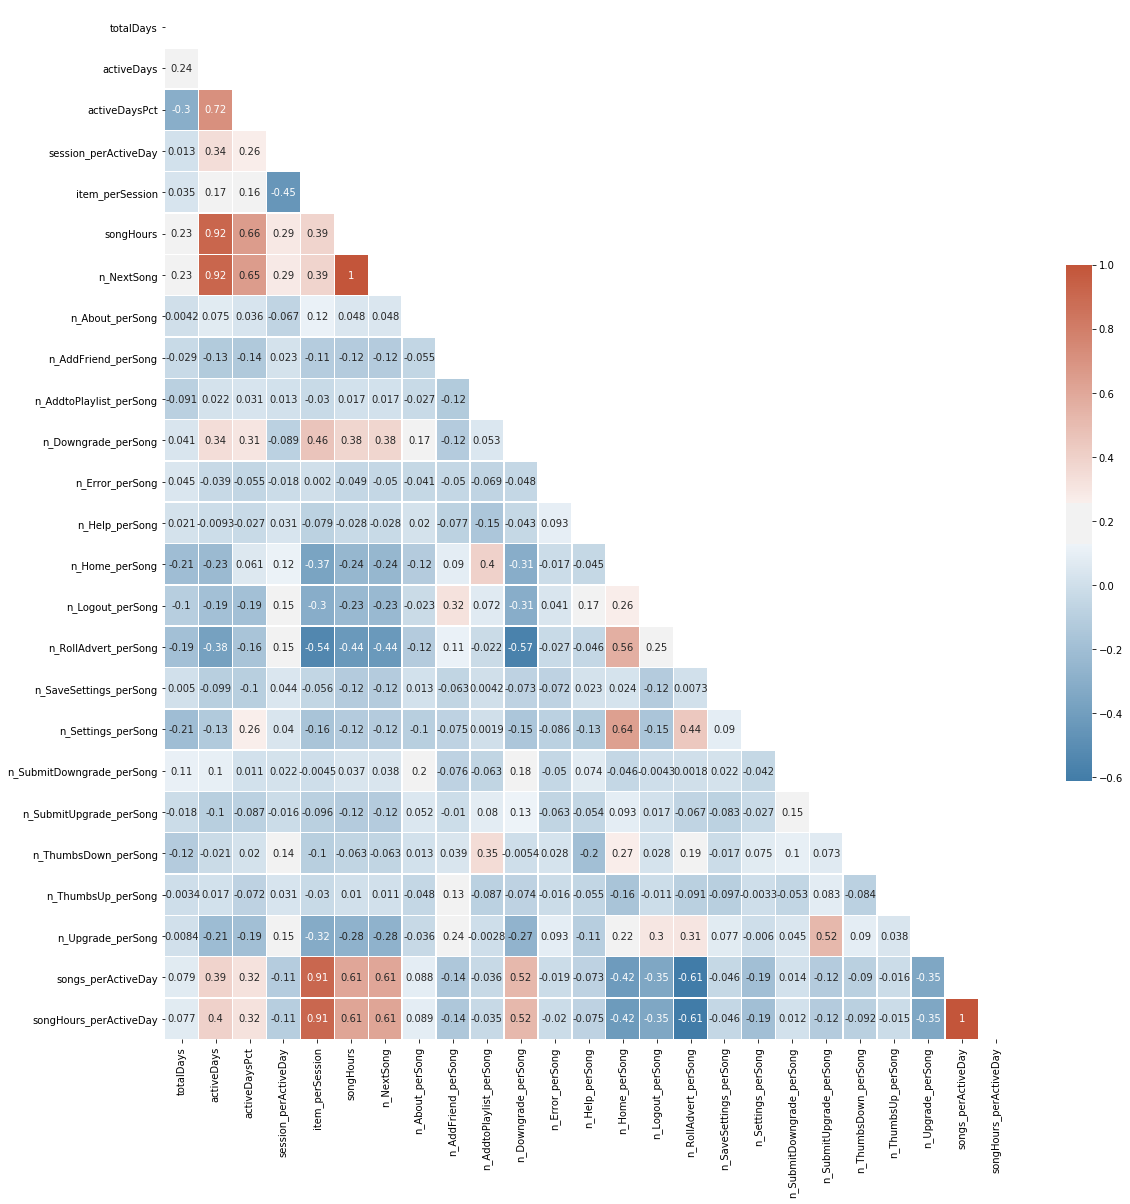

In [25]:
df6_num_cols_panda = df6.select(df6_num_cols).toPandas()
corrMatrix = df6_num_cols_panda.corr()

# Generate a mask for the upper triangle
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(240, 20, sep=20, n=20, as_cmap=True)
plt.figure(figsize=(19,19))
sn.heatmap(corrMatrix, annot=True, cmap=cmap, mask=mask, linewidths=.5, linecolor='white', cbar_kws={"shrink": .5})
plt.show()

In [26]:
# drop columns with correlation > 0.8
df6_num_cols_drop = ['activeDays', 'n_NextSong', 'songHours', 'songs_perActiveDay', 'item_perSession']
df6 = df6.drop(*df6_num_cols_drop)

In [27]:
# numeric columns after dropping high correlation features
numeric_cols = list(set(df6_num_cols) - set(df6_num_cols_drop))

# categorical_cols = ['gender', 'registrationYearMonth', 'state', 'system', 'level']
# 'gender', 'system', 'level' were chosen as categorical features for further analysis as each of them has 2 or 3 levels. 
categorical_cols = ['gender', 'system', 'level']

In [28]:
pandas_df6 = df6.toPandas()
pandas_df6['churn_label']= pandas_df6['churn'].map({1:'churn', 0:'not churn'})
pandas_df6.head(3)

,userId,churn,registrationYearMonth,gender,state,system,level,totalDays,activeDaysPct,session_perActiveDay,...,n_RollAdvert_perSong,n_SaveSettings_perSong,n_Settings_perSong,n_SubmitDowngrade_perSong,n_SubmitUpgrade_perSong,n_ThumbsDown_perSong,n_ThumbsUp_perSong,n_Upgrade_perSong,songHours_perActiveDay,churn_label
0,100010,0,2018-09,F,CT,Apple,free,55.64366,0.143772,0.875,...,0.18909,0.0,0.00000,0.0,0.00000,0.01818,0.06182,0.00727,2.32,not churn
1,200002,0,2018-09,M,WI,Apple,paid,70.07463,0.085623,1.000,...,0.01809,0.0,0.00775,0.0,0.00258,0.01550,0.05426,0.00517,4.35,not churn
2,125,1,2018-08,M,TX,Apple,free,71.31689,0.014022,1.000,...,0.12500,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.58,churn


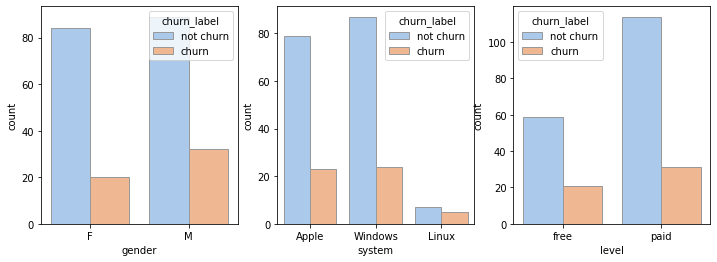

In [29]:
# number of users who churn vs not churn between/among gender/system/level
plt.figure(figsize=(12, 4))

for i, col in enumerate(categorical_cols):
    plt.subplot(1,3,i+1)
    sn.countplot(x=col, hue="churn_label", palette="pastel", edgecolor=".6", data=pandas_df6);

**Above countplots show clearly:**
1. Linux users have a higer percentage of churn users than not churn users.

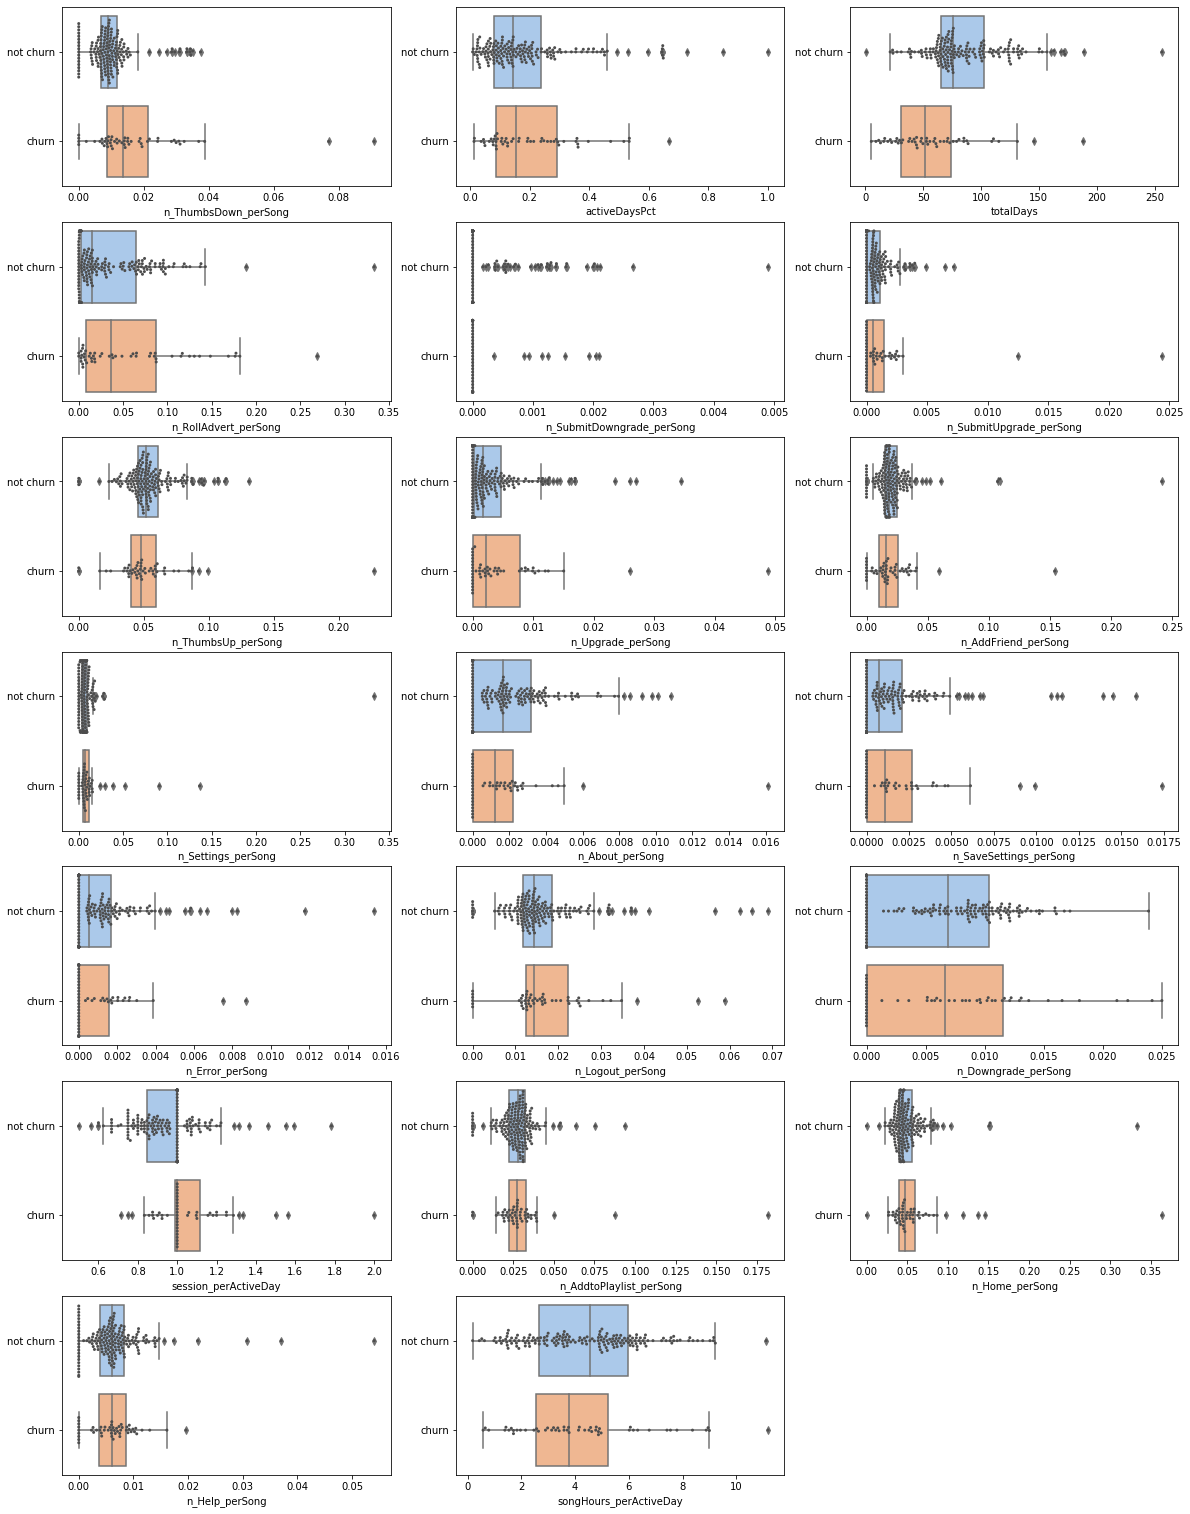

In [30]:
# boxplot of all numeric values between churn and not churn

fig = plt.figure(figsize=(20, 27))

for i, col in enumerate(numeric_cols):
    ax = fig.add_subplot(7,3,i+1)
    sn.boxplot(x=col, y="churn_label", data=pandas_df6, palette="pastel", ax=ax)
    sn.swarmplot(x=col, y="churn_label", data=pandas_df6, size=3, color=".3", linewidth=0)
    ax.set(ylabel="")

**Boxplots above show:**
1. Compared to not churn users, churn users have on average, more ThumbsDown_perSong, more session_perActiveDay, more RollAdvert_perSong,  higher Upgrade_perSong, higher Home_perSong, higher Settings_perSong, SaveSettings_perSong,  higher ThumbsDown_perSong than not churn users.
2. Compared to not churn users, churn users have on average, less songHours_perActiveDay, less About_perSong, less totalDays, less AddFriend_perSong, less ThumbsUp_perSong than not churn users.

In [31]:
f"df6 has a total of {len(df6.columns)} columns. Among them, there are {len(numeric_cols)} numeric columns, \
and {len(categorical_cols)} categorical columns. \
The rest 4 columns will not be used for analysis. They are 'userId', 'churn', 'registrationYearMonth', 'state'. "

"df6 has a total of 27 columns. Among them, there are 20 numeric columns, and 3 categorical columns. The rest 4 columns will not be used for analysis. They are 'userId', 'churn', 'registrationYearMonth', 'state'. "

In [32]:
stages = []

In [33]:
for col in categorical_cols:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[col + "Index"], outputCols=[col + "Vec"], dropLast=False)
    stages += [stringIndexer, encoder]

1. For Logistic Regression model, scale numeric columns will help compare feature importance much easier.
2. Random Forest and Gradient Boost Trees are tree-based model and hence does not require feature scaling.

In [34]:
# https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
# assemble all numeric cols into one col and scale will lose all column names

for col in numeric_cols:
    assembler = VectorAssembler(inputCols=[col], outputCol=col + "_Vec")
    scaler = MinMaxScaler(inputCol=col + "_Vec", outputCol=col + "_Scaled")
    stages += [assembler, scaler]

In [35]:
label_indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_indexer]

In [36]:
numericInputs = [c + "_Scaled" for c in numeric_cols]
categoricalInputs = [c + "Vec" for c in categorical_cols]
assembler = VectorAssembler(inputCols= numericInputs + categoricalInputs, outputCol='features')
stages += [assembler]

In [47]:
numericInputs

['n_SubmitDowngrade_perSong_Scaled',
 'totalDays_Scaled',
 'n_ThumbsDown_perSong_Scaled',
 'n_Logout_perSong_Scaled',
 'n_About_perSong_Scaled',
 'n_Downgrade_perSong_Scaled',
 'n_Error_perSong_Scaled',
 'songHours_perActiveDay_Scaled',
 'n_Help_perSong_Scaled',
 'n_AddFriend_perSong_Scaled',
 'n_Settings_perSong_Scaled',
 'n_ThumbsUp_perSong_Scaled',
 'n_SaveSettings_perSong_Scaled',
 'n_Home_perSong_Scaled',
 'session_perActiveDay_Scaled',
 'n_AddtoPlaylist_perSong_Scaled',
 'n_Upgrade_perSong_Scaled',
 'n_RollAdvert_perSong_Scaled',
 'n_SubmitUpgrade_perSong_Scaled',
 'activeDaysPct_Scaled']

In [48]:
stages

[StringIndexer_7f5dee473e35,
 OneHotEncoderEstimator_c7533d1cd07b,
 StringIndexer_97b76611568f,
 OneHotEncoderEstimator_98b37911e727,
 StringIndexer_efabe5c41888,
 OneHotEncoderEstimator_b8b0252718e7,
 VectorAssembler_9cb04c29834c,
 MinMaxScaler_e8647e782676,
 VectorAssembler_033726637eb9,
 MinMaxScaler_ef92c0454b8a,
 VectorAssembler_9640ed13c100,
 MinMaxScaler_1ccdbad9be76,
 VectorAssembler_901d8abd2e4c,
 MinMaxScaler_d15fb849e558,
 VectorAssembler_040dd7e959d4,
 MinMaxScaler_1851f9e01e0e,
 VectorAssembler_1eacec8591ba,
 MinMaxScaler_7cd0687f4859,
 VectorAssembler_03b450ea1f1b,
 MinMaxScaler_f10b3b254108,
 VectorAssembler_eba2a714efed,
 MinMaxScaler_96b408836ace,
 VectorAssembler_f5c583ef3ecc,
 MinMaxScaler_186d7c82be13,
 VectorAssembler_8ab746c71e96,
 MinMaxScaler_dfc593c913c2,
 VectorAssembler_c6b1b58c8130,
 MinMaxScaler_427db606a28a,
 VectorAssembler_0b1b3c1f03e0,
 MinMaxScaler_fc89399511c4,
 VectorAssembler_3883e3fb2c65,
 MinMaxScaler_495abd154d31,
 VectorAssembler_70909d0d1242,
 

In [37]:
pipeline = Pipeline(stages=stages)

In [38]:
df7 = pipeline.fit(df6).transform(df6)

In [51]:
len(df7.columns)

75

In [52]:
df7.toPandas()[['system', 'systemVec']].head(3)

,system,systemVec
0,Apple,"(0.0, 1.0, 0.0)"
1,Apple,"(0.0, 1.0, 0.0)"
2,Apple,"(0.0, 1.0, 0.0)"


In [53]:
df7.toPandas()[['gender', 'genderVec']].head(5)

,gender,genderVec
0,F,"(0.0, 1.0)"
1,M,"(1.0, 0.0)"
2,M,"(1.0, 0.0)"
3,F,"(0.0, 1.0)"
4,M,"(1.0, 0.0)"


In [54]:
df7.columns

['userId',
 'churn',
 'registrationYearMonth',
 'gender',
 'state',
 'system',
 'level',
 'totalDays',
 'activeDaysPct',
 'session_perActiveDay',
 'n_About_perSong',
 'n_AddFriend_perSong',
 'n_AddtoPlaylist_perSong',
 'n_Downgrade_perSong',
 'n_Error_perSong',
 'n_Help_perSong',
 'n_Home_perSong',
 'n_Logout_perSong',
 'n_RollAdvert_perSong',
 'n_SaveSettings_perSong',
 'n_Settings_perSong',
 'n_SubmitDowngrade_perSong',
 'n_SubmitUpgrade_perSong',
 'n_ThumbsDown_perSong',
 'n_ThumbsUp_perSong',
 'n_Upgrade_perSong',
 'songHours_perActiveDay',
 'genderIndex',
 'genderVec',
 'systemIndex',
 'systemVec',
 'levelIndex',
 'levelVec',
 'n_SubmitDowngrade_perSong_Vec',
 'n_SubmitDowngrade_perSong_Scaled',
 'totalDays_Vec',
 'totalDays_Scaled',
 'n_ThumbsDown_perSong_Vec',
 'n_ThumbsDown_perSong_Scaled',
 'n_Logout_perSong_Vec',
 'n_Logout_perSong_Scaled',
 'n_About_perSong_Vec',
 'n_About_perSong_Scaled',
 'n_Downgrade_perSong_Vec',
 'n_Downgrade_perSong_Scaled',
 'n_Error_perSong_Vec',
 'n

In [55]:
# features col is sparse 
df7.toPandas().head(5)

,userId,churn,registrationYearMonth,gender,state,system,level,totalDays,activeDaysPct,session_perActiveDay,...,n_Upgrade_perSong_Vec,n_Upgrade_perSong_Scaled,n_RollAdvert_perSong_Vec,n_RollAdvert_perSong_Scaled,n_SubmitUpgrade_perSong_Vec,n_SubmitUpgrade_perSong_Scaled,activeDaysPct_Vec,activeDaysPct_Scaled,label,features
0,100010,0,2018-09,F,CT,Apple,free,55.64366,0.143772,0.875000,...,[0.00727],[0.14903649036490366],[0.18909],[0.5672756727567275],[0.0],[0.0],[0.14377199113368988],[0.13684180986797748],0.0,"[0.0, 0.2139719576891746, 0.19997800021999781,..."
1,200002,0,2018-09,M,WI,Apple,paid,70.07463,0.085623,1.000000,...,[0.00517],[0.10598605986059861],[0.01809],[0.05427054270542705],[0.00258],[0.1057810578105781],[0.08562299609184265],[0.07822216556928967],0.0,"[0.0, 0.27048030471888945, 0.17049829501704983..."
2,125,1,2018-08,M,TX,Apple,free,71.31689,0.014022,1.000000,...,[0.0],[0.0],[0.125],[0.37500375003750036],[0.0],[0.0],[0.014021923765540123],[0.006041564887336099],1.0,"(0.0, 0.2753447080944861, 0.0, 0.0, 0.0, 0.0, ..."
3,124,0,2018-07,F,NJ,Apple,paid,131.55591,0.258445,0.852941,...,[0.0],[0.0],[0.00098],[0.0029400294002940026],[0.0],[0.0],[0.25844526290893555],[0.25244322993025126],0.0,"[0.0, 0.5112268038156977, 0.11054889451105489,..."
4,51,1,2018-09,M,KY,Windows,paid,19.45584,0.668180,0.769231,...,[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.6681798100471497],[0.6654941071266844],1.0,"[0.0, 0.0722688087803448, 0.1094489055109449, ..."


In [56]:
df7.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'n_SubmitDowngrade_perSong_Scaled_0'},
  {'idx': 1, 'name': 'totalDays_Scaled_0'},
  {'idx': 2, 'name': 'n_ThumbsDown_perSong_Scaled_0'},
  {'idx': 3, 'name': 'n_Logout_perSong_Scaled_0'},
  {'idx': 4, 'name': 'n_About_perSong_Scaled_0'},
  {'idx': 5, 'name': 'n_Downgrade_perSong_Scaled_0'},
  {'idx': 6, 'name': 'n_Error_perSong_Scaled_0'},
  {'idx': 7, 'name': 'songHours_perActiveDay_Scaled_0'},
  {'idx': 8, 'name': 'n_Help_perSong_Scaled_0'},
  {'idx': 9, 'name': 'n_AddFriend_perSong_Scaled_0'},
  {'idx': 10, 'name': 'n_Settings_perSong_Scaled_0'},
  {'idx': 11, 'name': 'n_ThumbsUp_perSong_Scaled_0'},
  {'idx': 12, 'name': 'n_SaveSettings_perSong_Scaled_0'},
  {'idx': 13, 'name': 'n_Home_perSong_Scaled_0'},
  {'idx': 14, 'name': 'session_perActiveDay_Scaled_0'},
  {'idx': 15, 'name': 'n_AddtoPlaylist_perSong_Scaled_0'},
  {'idx': 16, 'name': 'n_Upgrade_perSong_Scaled_0'},
  {'idx': 17, 'name': 'n_RollAdvert_perSong_Scaled_0'},
  {'idx': 18, 'name': 'n_

In [57]:
pd.DataFrame(df7.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+df7.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

,idx,name
7,0,n_SubmitDowngrade_perSong_Scaled_0
8,1,totalDays_Scaled_0
9,2,n_ThumbsDown_perSong_Scaled_0
10,3,n_Logout_perSong_Scaled_0
11,4,n_About_perSong_Scaled_0
12,5,n_Downgrade_perSong_Scaled_0
13,6,n_Error_perSong_Scaled_0
14,7,songHours_perActiveDay_Scaled_0
15,8,n_Help_perSong_Scaled_0
16,9,n_AddFriend_perSong_Scaled_0


In [39]:
feature_cols = [x["name"] for x in sorted(df7.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   df7.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
   key=lambda x: x["idx"])]

In [59]:
feature_cols

['n_SubmitDowngrade_perSong_Scaled_0',
 'totalDays_Scaled_0',
 'n_ThumbsDown_perSong_Scaled_0',
 'n_Logout_perSong_Scaled_0',
 'n_About_perSong_Scaled_0',
 'n_Downgrade_perSong_Scaled_0',
 'n_Error_perSong_Scaled_0',
 'songHours_perActiveDay_Scaled_0',
 'n_Help_perSong_Scaled_0',
 'n_AddFriend_perSong_Scaled_0',
 'n_Settings_perSong_Scaled_0',
 'n_ThumbsUp_perSong_Scaled_0',
 'n_SaveSettings_perSong_Scaled_0',
 'n_Home_perSong_Scaled_0',
 'session_perActiveDay_Scaled_0',
 'n_AddtoPlaylist_perSong_Scaled_0',
 'n_Upgrade_perSong_Scaled_0',
 'n_RollAdvert_perSong_Scaled_0',
 'n_SubmitUpgrade_perSong_Scaled_0',
 'activeDaysPct_Scaled_0',
 'genderVec_M',
 'genderVec_F',
 'systemVec_Windows',
 'systemVec_Apple',
 'systemVec_Linux',
 'levelVec_paid',
 'levelVec_free']

In [40]:
# select data for analysis
df8 = df7.select('label', 'features')

In [61]:
df8.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,0.2139719576...|
+-----+--------------------+
only showing top 1 row



In [57]:
# check if the data is balanced
df8.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  173|
|  1.0|   52|
+-----+-----+



In [62]:
# check if the data is balanced
df8.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  173|
|  1.0|   52|
+-----+-----+



In [41]:
# churn users are significantly less than not churn users
52/(52 + 173)

0.2311111111111111

In [42]:
# stratified sampling to make sure the train/test datasets have similar churn/not churn ratios to that of the whole dataset
train = df8.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=42)

In [65]:
# get counts of churn/not churn users in train dataset
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  147|
|  1.0|   44|
+-----+-----+



In [66]:
# check if the churn/not churn ratio in train dataset is close to that of the whole dataset. it is indeed very close.
44/(147 + 44)

0.23036649214659685

In [43]:
# use the rest as test dataset
test = df8.subtract(train)

In [44]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 191
Test Dataset Count: 34


In [26]:
def train_test_sampling(data, ratio=0.8, label='label', seed=42):
    train = data.sampleBy(col='label', fractions={0: ratio, 1: ratio}, seed=seed)
    test = data.subtract(train)
    return train, test

In [27]:
train, test = train_test_sampling(df8)

In [28]:
# define an evaluator. 
# for unbalanced binary classification, 'areaUnderROC' is recommended 
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC')

In [29]:
#1 logistic regression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')

# Create the parameter grid, add hyperparameters, and build the grid
grid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, .1]) \
        .addGrid(lr.elasticNetParam, [0, .5]) \
        .addGrid(lr.maxIter, [50, 100]) \
        .build()

# Create the parameter grid, add hyperparameters, and build the grid
grid1 = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01]) \
        .addGrid(lr.elasticNetParam, [0]) \
        .addGrid(lr.maxIter, [50]) \
        .build()

In [48]:
# Create the CrossValidator
cv_lr = CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator,
               numFolds = 4,
               seed = 42
               )

In [49]:
# 2 hours run
start_time = time.time()
lrModel = cv_lr.fit(train)
print("Logistic regression training time 8 parameter combos --- %s seconds ---" % (time.time() - start_time))

Logistic regression training time 8 parameter combos --- 783.6870720386505 seconds ---


In [50]:
# best model
lr_best_model = lrModel.bestModel

In [150]:
# Use the model to predict the test set
predictions = lr_best_model.transform(test)

In [152]:
# pyspark dataframe
# TN = predictions_t.filter((predictions_t.label == 0) & (predictions_t.prediction == 0)).count()

# pyspark sql
TN = predictions.filter('label = 0 and prediction = 0').count()
TP = predictions.filter('label = 1 and prediction = 1').count()
FN = predictions.filter('label = 1 and prediction = 0').count()
FP = predictions.filter('label = 0 and prediction = 1').count()
print(TN, TP, FN, FP)

26 0 8 0


In [156]:
# calculate accuracy, precision, recall, F1-score, and areaUnderROC
accuracy = (TN + TP) / (TN + TP + FN + FP)

if TP == 0 and FP == 0:
    precision = 0
else:
    precision = TP / (TP + FP)
    
if TP==0 and FN==0:
    recall = 0
else:
    recall = TP / (TP + FN)
    
if precision==0 and recall==0:
    F=0
else:
    F =  2 * (precision*recall) / (precision + recall)

In [157]:
print('test accuracy: %0.3f' % accuracy)
print('test precision: %0.3f' % precision)
print('test recall: %0.3f' % recall)
print('test F1 score: %0.3f' % F)
print('test Area Under ROC: %0.3f' %  evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))

test accuracy: 0.765
test precision: 0.000
test recall: 0.000
test F1 score: 0.000
test Area Under ROC: 0.649


In [153]:
lr_best_model.getOrDefault('regParam')
lr_best_model.getOrDefault('elasticNetParam')
lr_best_model.getOrDefault('maxIter')

50

In [30]:
def metrics_calculation(model, data):
    predictions = model.transform(data)

    TN = predictions.filter('label = 0 and prediction = 0').count()
    TP = predictions.filter('label = 1 and prediction = 1').count()
    FN = predictions.filter('label = 1 and prediction = 0').count()
    FP = predictions.filter('label = 0 and prediction = 1').count()

    # calculate accuracy, precision, recall, F1-score, and areaUnderROC
    accuracy = (TN + TP) / (TN + TP + FN + FP)

    if TP == 0 and FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP==0 and FN==0:
        recall = 0
    else:
        recall = TP / (TP + FN)

    if precision==0 and recall==0:
        F1=0
    else:
        F1 =  2 * (precision*recall) / (precision + recall)
        
    areaUnderROC = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    
    model_metrics = pd.DataFrame({'accuracy':[accuracy], 'precision':[precision], \
                                  'recall':[recall], 'F1':[F1], 'areaUnderROC':[areaUnderROC]})
    
#    model_metrics.insert(0, 'model', model.uid.split('_')[0])
    return model_metrics

In [31]:
def metrics_train_test(model, train, test):

    train_metrics = metrics_calculation(model=model, data=train)
    test_metrics = metrics_calculation(model=model, data=test)
    
    model_metrics = pd.concat(dict(TRAIN = train_metrics, TEST = test_metrics),axis=1)

    model_metrics.insert(0, 'model', model.uid.split('_')[0]) 
    return model_metrics

In [32]:
def fit_model(base_model, grid, evaluator, data, numFolds=4, seed=42):
    
    cv = CrossValidator(estimator=base_model,
               estimatorParamMaps=grid,
               evaluator=evaluator,
               numFolds = numFolds,
               seed = seed
               )
    
    start_time = time.time()
    model = cv.fit(data)
    t = time.time() - start_time
        
#    best_model = model.bestModel

    return model, t

In [33]:
def best_model_and_all_metrics(base_model, grid, evaluator, data, numFolds=4, seed=42):
    
    train, test = train_test_sampling(data=data)
    
    model, t = fit_model(base_model=base_model, grid=grid, \
                               evaluator=evaluator, data=train, numFolds=numFolds, seed=seed)
    
    best_model = model.bestModel
    model_metrics = metrics_train_test(model=best_model, test=test, train=train)
    model_metrics['TRAIN', 'training time (s)'] = t
#    model_metrics = model_metrics.sort_index(axis=1, ascending=False)
        
    return best_model, model_metrics
    

In [34]:
#2 RandomForestClassifier
rf = RandomForestClassifier()

# Create the parameter grid, add hyperparameters, and build the grid
grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxDepth, [3, 5, 10]) \
        .build()

# Create the parameter grid, add hyperparameters, and build the grid
grid2 = ParamGridBuilder() \
        .addGrid(rf.numTrees, [30]) \
        .addGrid(rf.maxDepth, [5]) \
        .build()

In [35]:
#3 GBTClassifier
gbt = GBTClassifier()

# Create the parameter grid, add hyperparameters, and build the grid
grid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [3, 5, 10]) \
        .addGrid(gbt.maxIter, [10, 20, 30]) \
        .build()

# Create the parameter grid, add hyperparameters, and build the grid
grid3 = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5]) \
        .addGrid(gbt.maxIter, [30]) \
        .build()

In [36]:
lr_best_model, Lr_model_metrics = best_model_and_all_metrics(base_model=lr, grid=grid1, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)
rf_best_model, rf_model_metrics = best_model_and_all_metrics(base_model=rf, grid=grid2, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)
gbt_best_model, gbt_model_metrics = best_model_and_all_metrics(base_model=gbt, grid=grid3, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)

In [38]:
pd.concat([Lr_model_metrics, rf_model_metrics, gbt_model_metrics])

model     TRAIN                                \
                           accuracy precision    recall        F1   
0      LogisticRegression  0.848168       0.8  0.454545  0.579710   
0  RandomForestClassifier  0.926702       1.0  0.681818  0.810811   
0           GBTClassifier  1.000000       1.0  1.000000  1.000000   

                    TEST                                          \
  areaUnderROC  accuracy precision recall        F1 areaUnderROC   
0     0.869975  0.764706  0.000000  0.000  0.000000     0.649038   
0     0.986240  0.794118  1.000000  0.125  0.222222     0.826923   
0     1.000000  0.823529  0.666667  0.500  0.571429     0.798077   

              TRAIN  
  training time (s)  
0        706.305713  
0        216.585559  
0       3531.584639

In [42]:
lr_best_model.save('lr_best_model.pkl')

In [43]:
rf_best_model.save('rf_best_model.pkl')

In [44]:
gbt_best_model.save('gbt_best_model.pkl')

In [39]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

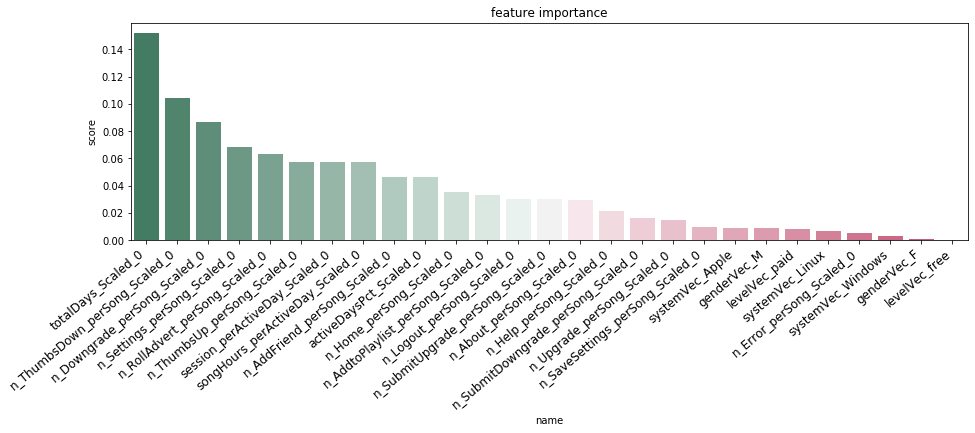

In [40]:
df_feature_importance = ExtractFeatureImp(rf_best_model.featureImportances, train, "features")

# plot model's correlation coefficients
plt.figure(figsize=(15, 4));

palette = sn.diverging_palette(150, 0, n=27)

sn.barplot(x=df_feature_importance.name, y=df_feature_importance.score, data=df_feature_importance, palette=palette)
plt.xticks(rotation=40, ha='right', fontsize=12)
plt.title('feature importance');

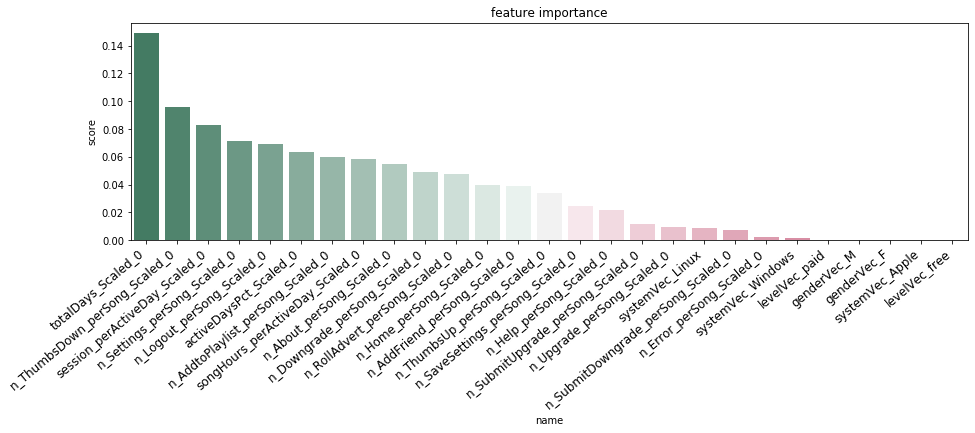

In [41]:
df_feature_importance = ExtractFeatureImp(gbt_best_model.featureImportances, train, "features")

# plot model's correlation coefficients
plt.figure(figsize=(15, 4));

palette = sn.diverging_palette(150, 0, n=27)

sn.barplot(x=df_feature_importance.name, y=df_feature_importance.score, data=df_feature_importance, palette=palette)
plt.xticks(rotation=40, ha='right', fontsize=12)
plt.title('feature importance');

In [63]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. **You can start by exploring aggregates on these two groups of users**, observing how much of a specific action they experienced **per a certain time unit or number of songs played.**

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- **Write a script to extract the necessary features from the smaller subset of data**
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest **using F1 score as the metric to optimize.**

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.